**Implementación**

El departamento de calidad de una empresa de alimentación se encarga de medir el contenido en grasa de la carne que comercializa. Este estudio se realiza mediante técnicas de analítica química, un proceso relativamente costoso en tiempo y recursos. Una alternativa que permitiría reducir costes y optimizar tiempo es emplear un espectrofotómetro (instrumento capaz de detectar la absorbancia que tiene un material a diferentes tipos de luz en función de sus características) e inferir el contenido en grasa a partir de sus medidas.

Antes de dar por válida esta nueva técnica, la empresa necesita comprobar qué margen de error tiene respecto al análisis químico. Para ello, se mide el espectro de absorbancia a 100 longitudes de onda en 215 muestras de carne, cuyo contenido en grasa se obtiene también por análisis químico, y se entrena un modelo con el objetivo de predecir el contenido en grasa a partir de los valores dados por el espectrofotómetro.

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [19]:
# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [20]:
datos = pd.read_csv('https://raw.githubusercontent.com/Laura-Martinez182/Datasets/main/meatspec.csv')
datos = datos.drop(columns = datos.columns[0])
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Columns: 101 entries, V1 to fat
dtypes: float64(101)
memory usage: 169.8 KB


**División de los datos en train y test**

In [21]:
X = datos.drop(columns='fat')
y = datos['fat']

X_train, X_test, y_train, y_test = train_test_split( X,
                                        y.values.reshape(-1,1),
                                        train_size = 0.7,
                                        random_state = 1234,
                                        shuffle = True )

## **Mínimos cuadrados (OLS)**

In [22]:
modelo = LinearRegression(normalize=True)
modelo.fit(X = X_train, y = y_train)

LinearRegression(normalize=True)

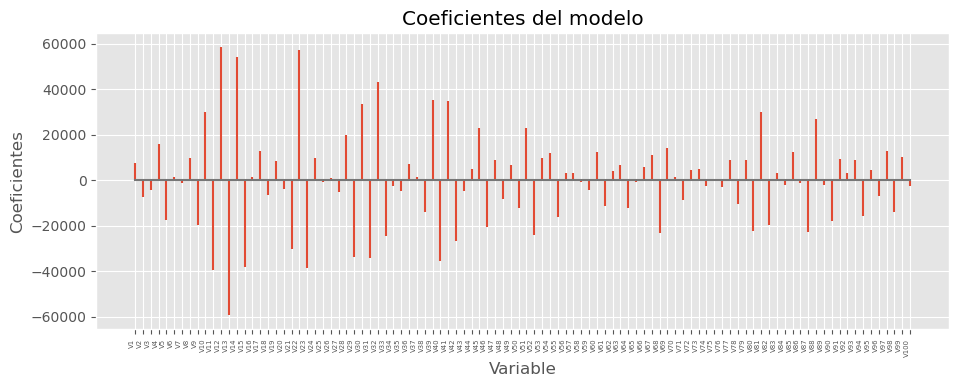

In [23]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo');

In [24]:
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([36.88226752, 62.4799266 , 61.04825535,  9.95161352, 18.11993067,
        6.56158193, 28.42860453,  9.18085599, 15.56800749, 16.50461443])

In [25]:
# Error de test del modelo 
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 3.8396675855998725


Las predicciones del modelo final se alejan en promedio 3.84 unidades del valor real.

## **Ridge**

In [26]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto RidgeCV utiliza el mean squared error
modelo = RidgeCV(
            alphas = np.logspace(-10, 2, 200),
            fit_intercept = True,
    		normalize = True,
            store_cv_values = True)

_ = modelo.fit(X = X_train, y = y_train)

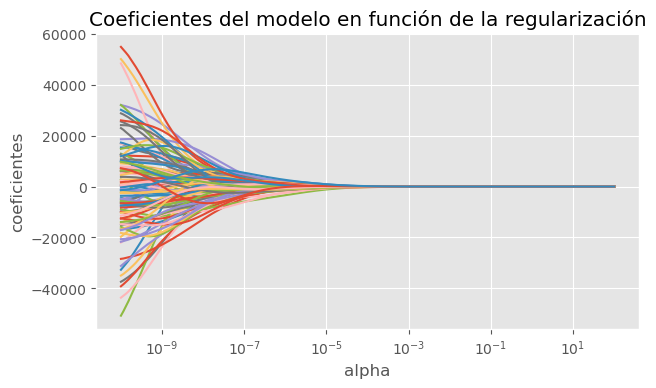

In [27]:
# Evolución de los coeficientes en función de alpha
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

A medida que aumenta el valor de alpha, la regularización es mayor y el valor de los coeficientes se reduce.

In [28]:
# Evolución del error en función de alpha
# modelo.cv_values almacena el mse de cv para cada valor de alpha

mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]



In [29]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 2.9673024081888725e-08


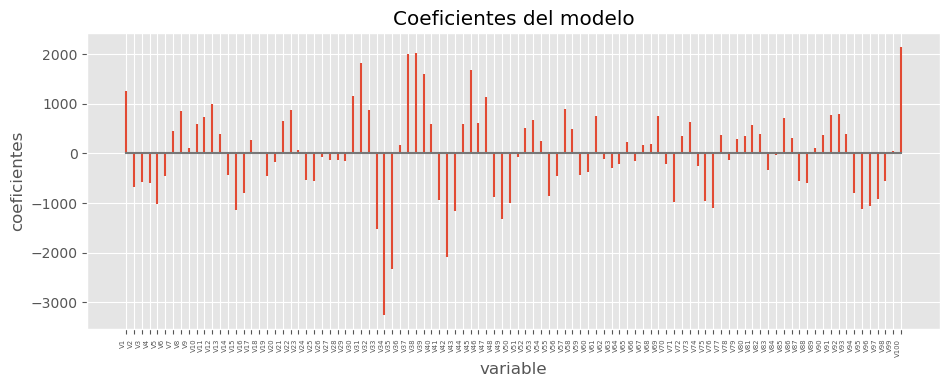

In [30]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

El orden de magnitud de los coeficientes es mucho menor.

In [31]:
# Predicciones test
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([43.14618033, 40.39692878, 51.81659361,  9.99905132, 17.88495762,
        7.64777879, 28.1763814 ,  8.2146239 , 14.71056249, 14.3826998 ])

In [32]:
# Error de test del modelo 
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 2.4486453846210914


## **Comparación**

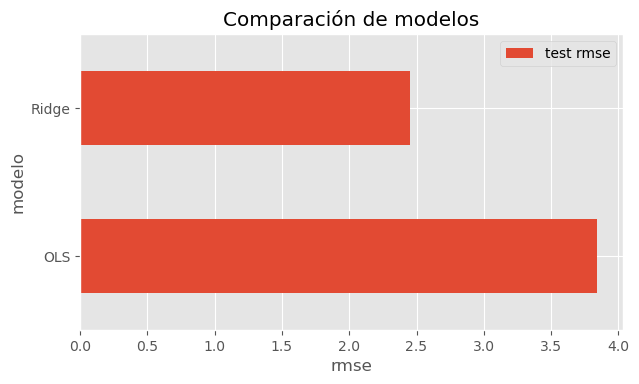

In [33]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge'],
                    'test rmse': [rmse_ols, rmse_ridge]})

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');